# REVISION INEGI

En el estudio realizado por el INEGI se utilizan una serie de métodos estadísticos con el propósito de representar las causas, formas y consecuencias de tener tasas de homicidios tan altas. Este notebook será un recuento de estas técnicas estadísticas y una propuesta de programación en Python.


## AVPP

El primer método enunciado en el documento es el AVPP, o Años de Vida Productivos Perdidos. El INEGI, en la página 14, propone esta forma de representar los años de vida perdidos por la víctima de homicidio. Este indicador nos permite demostrar que el aumento de los homicidios es un problema que puede afectar directamente nuestro bienestar.



**Propuesta de código:**

In [1]:



def calcular_avpp(victimas_df, col_edad=0, col_anio_muerte=1,
                  esperanza_vida_df=None, col_ev_anio=0, col_ev_valor=1):
    """
    Calcula los Años de Vida Potencialmente Perdidos (AVPP) por homicidio.

    Parámetros:
    - victimas_df: DataFrame con columnas de edad y año de fallecimiento.
    - esperanza_vida_df: DataFrame con columnas de año y esperanza de vida.

    Librerías necesarias:
    ---------------------
    - pandas
    """
    avpp = 0
    for i in range(len(victimas_df)):
        edad = victimas_df.iloc[i, col_edad]
        anio_muerte = victimas_df.iloc[i, col_anio_muerte]

        izquierda = 0
        derecha = len(esperanza_vida_df) - 1
        esperanza = None

        while izquierda <= derecha:
            medio = (izquierda + derecha) // 2
            anio_ev = esperanza_vida_df.iloc[medio, col_ev_anio]

            if anio_ev == anio_muerte:
                esperanza = esperanza_vida_df.iloc[medio, col_ev_valor]
                break
            elif anio_ev < anio_muerte:
                izquierda = medio + 1
            else:
                derecha = medio - 1

        if esperanza is not None:
            avpp += max(0, esperanza - edad)

    return avpp





## Tasas Bayesianas Empiricas


Las tasas bayesianas empíricas son un método para suavizar las tasas crudas hacia una tasa media. Son útiles en el caso explicado por el INEGI, donde ciertos municipios se ven afectados debido a su baja población.


**Tasa bayesiana empírica suavizada:**

$$
\tilde{\theta}_i = w_i \hat{\theta}_i + (1 - w_i) \bar{\theta}
$$

**Cálculo del peso $w_i$:**

$$
w_i = \frac{s^2}{s^2 + \dfrac{\hat{\theta}_i (1 - \hat{\theta}_i)}{n_i}}
$$

- $y_i$: número de eventos observados en el área $i$
- $n_i$: población del área $i$
- $\hat{\theta}_i = \dfrac{y_i}{n_i}$: tasa cruda observada
- $\bar{\theta}$: tasa global o promedio
- $w_i$: peso según varianza y población

### Proposición de código:

In [2]:
import numpy as np
import pandas as pd

def tsb(data, p_id=0, p_event=1, p_population=2):
    """
Objetivo
--------

Calcula las tasas Bayesiano-Empíricas a partir de tasas brutas observadas.

Parámetros
----------
data : pandas.DataFrame
    Datos.
p_id : int
    Índice de la columna del identificador.
p_event : int
    Índice de la columna del número de eventos.
p_population : int
    Índice de la columna de la población.

Return
-------
array
    Array con las tasas Bayesiano-Empíricas calculadas para cada observación.
"""



    tasas_crudas = []
    varianzas_intra = []

    for i in range(len(data)):
        t_c = data.iloc[i, p_event] / data.iloc[i, p_population]
        tasas_crudas.append(t_c)
        v_i = (t_c * (1 - t_c)) / data.iloc[i, p_population]
        varianzas_intra.append(v_i)


    varianza_entre = np.var(tasas_crudas, ddof=1)

    tasa_global = np.mean(tasas_crudas)

    tasas_sb = []

    for i in range(len(data)):
        w_i = varianza_entre / (varianza_entre + varianzas_intra[i])
        t_sb = w_i * tasas_crudas[i] + (1 - w_i) * tasa_global
        tasas_sb.append((data.iloc[i, p_id], t_sb))
    return tasas_sb


El código funciona, pero el problema es que, en estadística bayesiana, se admite que las tasas crudas es decir, la división entre los eventos observados y la población observada son más precisas mientras mayor sea la población observada. La solución es tratar las observaciones como variables aleatorias.

Es una librería capaz de crear modelos bayesianos. Primero se debe elegir un priori, que es la variable aleatoria que representa el parámetro o la probabilidad de que ocurra un evento. En nuestro caso, sería la cantidad de litros que consume un país. Luego, se debe elegir la likelihood (verosimilitud); en nuestro ejemplo, podría ser la cantidad de países consumidores de alcohol. Finalmente, se utiliza un método para estimar la distribución posterior, que en nuestro caso será Monte Carlo.Es una librería capaz de crear modelos bayesianos. Primero se debe elegir un priori, que es la variable aleatoria que representa el parámetro o la probabilidad de que ocurra un evento. En nuestro caso, sería la cantidad de litros que consume un país. Luego, se debe elegir la likelihood (verosimilitud); en nuestro ejemplo, podría ser la cantidad de países consumidores de alcohol. Finalmente, se utiliza un método para estimar la distribución posterior, que en nuestro caso será Monte Carlo.

## PyMC

Es una libreria capaz de hacer modelos bayesiannos. Primero se tiene que elegir un Priori que es la variable alateoria representando el parametro o la probabilidad que el evento suceda. En nuestro caso es cuantos litros consume un pais. Luego se necesita elegir un Likelyhood en el caso de nuestro ejemplo va ser cuantos paises son consumidores de alchool. Se termina con el metodo utilizado en nuestro caso va ser Monte Carlo.

La elección del prior es importante porque facilita que nuestro modelo obtenga una distribución posterior más precisa y con mayor rapidez. Existen cuatro tipos principales de priors:

Prior informativo:
Es un prior específico que se utiliza cuando se conoce información previa sobre el parámetro. Por ejemplo, si se sabe que el parámetro está cerca de cierto valor, podemos usar una distribución normal centrada en ese valor:

𝜃
∼
𝑁
(
𝜇
,
𝜎
2
)
θ∼N(μ,σ
2
 )
donde
𝜇
μ representa la media esperada del parámetro y
𝜎
2
σ
2
  su varianza.

Prior no informativo (o débilmente informativo):
Se utiliza cuando no se tiene información previa sobre el parámetro o se desea que el prior tenga el menor impacto posible sobre la posterior. Un ejemplo común es el prior uniforme:

𝜃
∼
Uniform
(
𝑎
,
𝑏
)
θ∼Uniform(a,b)
donde todos los valores de
𝜃
θ entre
𝑎
a y
𝑏
b son igualmente probables.

Prior empírico:
Un prior empírico se estima a partir de los datos disponibles, en lugar de ser completamente especificado a priori. Se calcula ajustando una distribución a un conjunto de datos preliminares. Por ejemplo, se puede estimar un prior normal a partir del promedio y la varianza muestral de datos observados:

𝜃
∼
𝑁
(
𝑥
ˉ
,
𝑠
2
)
θ∼N(
x
ˉ
 ,s
2
 )
Prior jerárquico:
Se utiliza cuando se modelan parámetros que varían entre grupos (por ejemplo, regiones, municipios, etc.). Aquí, los parámetros tienen su propia distribución, cuyos parámetros a su vez también tienen priors. Por ejemplo:

𝜃
𝑖
∼
𝑁
(
𝜇
,
𝜏
2
)
con
𝜇
∼
𝑁
(
0
,
𝜎
2
)
θ
i
​
 ∼N(μ,τ
2
 )conμ∼N(0,σ
2
 )
Este enfoque es muy útil en modelos multinivel o de datos agrupados, como el caso del análisis de tasas de homicidio por municipio.


## Rupturas Naturales de Jenks

Las rupturas naturales de Jenks son un método de clasificación utilizado para minimizar la varianza intra-grupo y maximizar la varianza inter-grupos. En otras palabras, crea grupos con poca diferencia entre los individuos dentro de cada grupo, pero maximiza la diferencia entre los grupos. Este algoritmo es útil cuando los grupos están bien definidos, pero si todos los grupos contienen varianzas relativamente similares, su utilidad disminuye.

## Aplicación en Python

La librería jenkspy permite realizar de manera sencilla estas rupturas naturales (natural breaks). Solo necesita los datos y el número de clases para generar las divisiones.

In [3]:
import jenkspy

# Ejemplo de datos (lista de números)
data = [1, 2, 2, 3, 4, 5, 10, 11, 15, 20, 21, 22, 23, 24]

# Número de clases que quieres (ejemplo: 3)
num_classes = 5

# Calcular los cortes (breaks)
breaks = jenkspy.jenks_breaks(data, n_classes=num_classes)

print("Rupturas naturales (Jenks breaks):", breaks)


Rupturas naturales (Jenks breaks): [np.int64(1), np.int64(3), np.int64(5), np.int64(11), np.int64(15), np.int64(24)]


Es un metodo de clasificacion util lo unico malo de este codigo es que propone donde hacer las rupturas pero no devuelve las classes en array separados. El otro problema es que no se sabe cual es el numero de classes optimas por lo general se tiene que acompañar de literaturo o algunos metodos como el metodo del codo con ayuda del GVF.

## Indice de Moran

El índice de Moran es una herramienta estadística utilizada para evaluar si existe autocorrelación espacial.
En otras palabras, busca determinar si hay correlación en la forma en que los datos están distribuidos espacialmente.
La interpretación del índice es sencilla: sus valores van de -1 a 1.

$$
I = \frac{n}{W} \cdot \frac{\sum_{i=1}^n \sum_{j=1}^n w_{ij} (x_i - \bar{x})(x_j - \bar{x})}{\sum_{i=1}^n (x_i - \bar{x})^2}
$$

-Un valor cercano a -1 indica autocorrelación negativa (distribución dispersa o repulsiva).

-Un valor cercano a 0 sugiere una distribución aleatoria (sin patrón espacial).

-Un valor cercano a 1 indica autocorrelación positiva (zonas similares están agrupadas).

Otra utilidad del índice de Moran es evaluar si un espacio es susceptible al clustering.
En nuestro caso específico, necesitamos encontrar un índice de Moran alto para justificar el uso de técnicas de agrupamiento (clustering).El índice de Moran es una herramienta estadística utilizada para evaluar si existe autocorrelación espacial.

$$
E[I] = -\frac{1}{n-1}
$$

La fórmula representa el valor esperado del Índice de Moran bajo la hipótesis nula, es decir, cuando se asume que los datos están distribuidos aleatoriamente en el espacio. Mientras más cercano esté el valor observado del índice a este valor esperado, más aleatorio son los datos.

## Aplicación en Python

Utilizando un archivo GeoJSON y la librería esda, podemos calcular el Índice de Moran. Además, la librería esda ofrece muchas otras funciones útiles para análisis espacial que podremos explorar en el futuro.

C:\Users\estev\AppData\Local\Temp\ipykernel_25912\2980973638.py:14: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(municipios)


Índice de Moran: 0.7992889291023314
Valor p (permutaciones): 0.001
Valor Z-Scores: 24.97981926201759


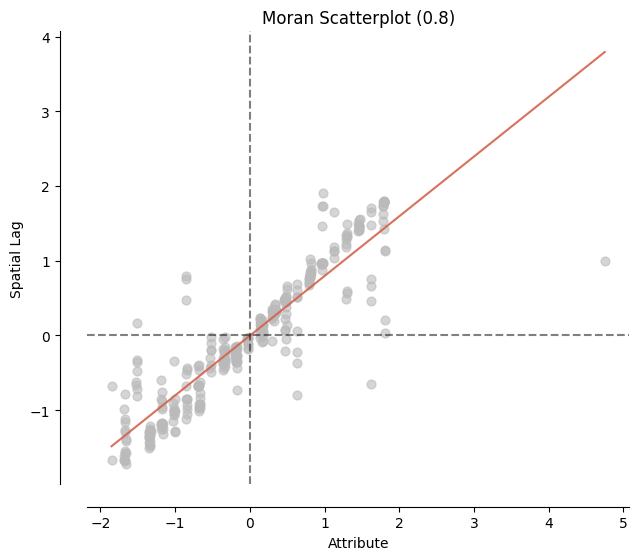

In [4]:
import geopandas as gpd
from esda.moran import Moran
from libpysal.weights import Queen
import matplotlib.pyplot as plt



municipios = gpd.read_file(r'C:\Users\estev\Downloads\muni.json')
municipios["id"] = pd.to_numeric(municipios["id"], errors='coerce')

variable = municipios["id"].astype(float).values


w = Queen.from_dataframe(municipios)
w.transform = 'r'


moran = Moran(variable, w)


print(f"Índice de Moran: {moran.I}")
print(f"Valor p (permutaciones): {moran.p_sim}")
print(f"Valor Z-Scores: {moran.z_sim}")


from splot.esda import moran_scatterplot
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()


Obviamente aquí es un pésimo ejemplo porque estamos usando los ID como variable, pero es para dar a entender lo poderosa que puede ser esta herramienta. El test proporciona un valor llamado p, que ayuda a validar si un patrón es aleatorio o no. Cuando p es menor que 0.05, significa que el valor estadístico es significativo, lo que indica que es poco probable que el resultado observado haya ocurrido por azar. En cambio, cuando p es mayor que 0.05, el resultado no es estadísticamente significativo, por lo que no se puede rechazar la hipótesis de aleatoriedad, es decir, es más probable que el patrón observado sea producto del azar.

### Getis-Ord GI*

Es un índice utilizado por el INEGI para analizar si existe una aglomeración significativa en el espacio. En el contexto del documento, el INEGI busca identificar cómo se distribuyen las zonas calientes de homicidios y aquellas que no lo son. A diferencia del Índice de Moran, que se utiliza para detectar si existen aglomeraciones espaciales, el estadístico Getis-Ord Gi* permite determinar si dichas aglomeraciones son estadísticamente significativas.

In [5]:
from esda.getisord import G_Local


g_local = G_Local(variable, w)

i_vals = g_local.Gs
p_vals = g_local.p_sim
z_scores = g_local.Zs


print(f"Getis-Ord Gi* (G_i*) en la zona 0: {i_vals[0]}")
print(f"Valor p (permutaciones) en la zona 0: {p_vals[0]}")
print(f"Z-Score en la zona 0: {z_scores[0]}")

Getis-Ord Gi* (G_i*) en la zona 0: 0.00030019337131450906
Valor p (permutaciones) en la zona 0: 0.001
Z-Score en la zona 0: -1.6725692008227964


A diferencia del Índice de Moran, que es general, el Getis-Ord Gi* se calcula para cada municipio de manera separada. Obviamente, aquí estamos usando los IDs como ejemplo, por lo que los resultados no tienen mucho interés. Sin embargo, este código sirve como guía para futuros análisis.